In [2]:
import yfinance as yahoo
import pandas as pd
import scipy.optimize as sco
from scipy import stats
import numpy as np

In [3]:
volume = yahoo.download(tickers="AAPL.BA ABT.BA AIG.BA AMD.BA "
                              "AMZN.BA BA.BA BABA.BA  BMY.BA BBD.BA  BBV.BA "
                              "C.BA CVX.BA DISN.BA ERJ.BA DESP.BA FB.BA GE.BA "
                              "GLNT.BA GOLD.BA GOOGL.BA GS.BA HPQ.BA JPM.BA OGZD.BA "
                              "KO.BA MELI.BA MRK.BA MMM.BA MSFT.BA NEM.BA NFLX.BA "
                              "PBR.BA PG.BA RIO.BA TSLA.BA TRIP.BA V.BA "
                              "VALE.BA WFC.BA WMT.BA X.BA", period="30d")['Volume']

[*********************100%***********************]  41 of 41 completed


In [4]:
liquidity = volume.sum()
liquidity = liquidity.sort_values(axis=0, ascending=False)
liquidity = liquidity.head(15) #choose 10 of 15, due to price allocation
liquidity

BBD.BA     1873513.0
WFC.BA     1108570.0
KO.BA       664030.0
VALE.BA     546748.0
AAPL.BA     488830.0
DESP.BA     268792.0
GE.BA       208135.0
AMZN.BA     191880.0
ERJ.BA      182958.0
MSFT.BA     171080.0
X.BA        168840.0
BABA.BA     137070.0
C.BA        124527.0
JPM.BA      117835.0
BBV.BA       92147.0
dtype: float64

In [6]:
tickets = ['BBD.BA', 'WFC.BA', 'KO.BA', 'VALE.BA', 'AAPL.BA', 'GE.BA', 'MSFT.BA', 'X.BA', 'C.BA', 'JPM.BA']

In [8]:
df = yahoo.download(tickers=tickets, period="30d", interval="2m")['Adj Close'] 
noa = len(df.columns)
weigths = np.random.random(noa)
weigths /= np.sum(weigths)
days = 252
alpha = 0.05
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0.0

[*********************100%***********************]  10 of 10 completed


In [9]:
def calc_portfolio_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_var

def min_VaR(mean_returns, cov, alpha, days):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha, days)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,0.3)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result


In [12]:
min_port_VaR = min_VaR(mean_returns, cov, alpha, days)

minimal_VaR = pd.DataFrame(index=df.columns)
minimal_VaR['weigths'] = pd.DataFrame([round(x,4) for x in min_port_VaR['x']],index=df.columns)
minimal_VaR.weigths.sort_values(axis=0,ascending=False)

MSFT.BA    0.1630
KO.BA      0.1580
AAPL.BA    0.1379
VALE.BA    0.1343
C.BA       0.0865
JPM.BA     0.0855
BBD.BA     0.0791
GE.BA      0.0788
WFC.BA     0.0625
X.BA       0.0145
Name: weigths, dtype: float64

In [13]:
data = yahoo.download(tickets, period="30d")['Adj Close']

[*********************100%***********************]  10 of 10 completed


In [14]:
portfolio = data * minimal_VaR.weigths

retorno = portfolio.T.sum().pct_change().cumsum()

In [16]:
import matplotlib.pyplot as plt

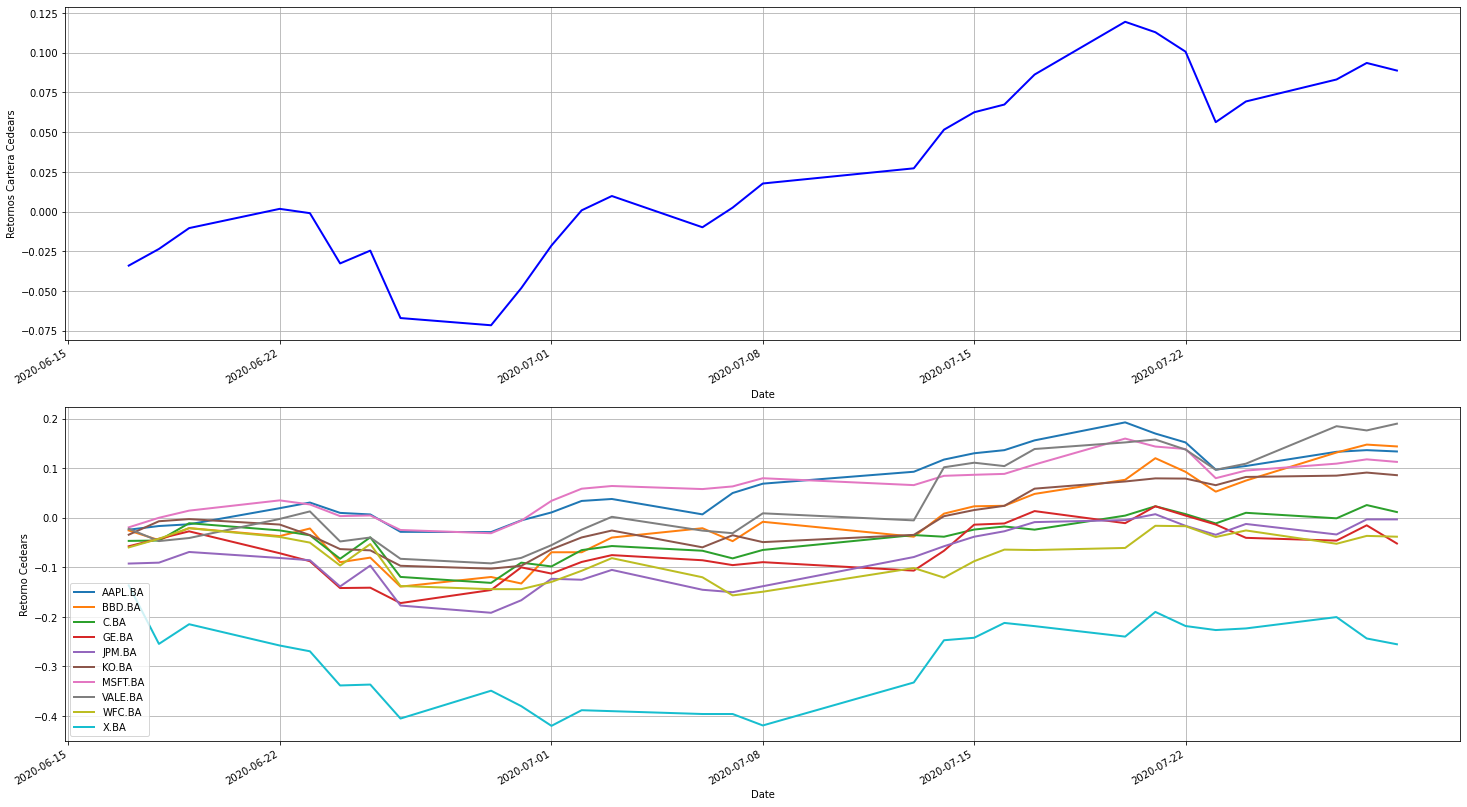

In [25]:
fig = plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(211, ylabel='Retornos Cartera Cedears')
retorno.plot(ax=ax1, color='b', lw=2.)
ax1.grid()
ax2 = fig.add_subplot(212, ylabel='Retorno Cedears')
portfolio.pct_change().cumsum().plot(ax=ax2, lw=2., legend=True)
ax2.grid()
plt.show()
